In [1]:
import sqlite3
import pandas as pd
pd.options.display.max_rows = 999

# Consultar datos
conn = sqlite3.connect('sp500_2.db')
cursor = conn.cursor()
cursor.execute("SELECT * FROM acciones")
column_names = [description[0] for description in cursor.description]
filas = cursor.fetchall()

# Guardar los datos en un dataframe
df = pd.DataFrame(filas, columns=column_names)
df.head(3)

,id,address1,address2,fax,prevName,ipoExpectedDate,city,state,zip,country,...,fiftyDayAverageChange,fiftyDayAverageChangePercent,twoHundredDayAverageChange,twoHundredDayAverageChangePercent,sourceInterval,exchangeDataDelayedBy,averageAnalystRating,cryptoTradeable,displayName,trailingPegRatio
0,1,3M Center,None,None,None,None,Saint Paul,MN,55144-1000,United States,...,-4.572601,-0.030604,13.741852,0.104821,15.0,0.0,2.2 - Buy,None,None,2.6157
1,2,11270 West Park Place,Suite 170,None,None,None,Milwaukee,WI,53224,United States,...,-1.777603,-0.026379,-10.458702,-0.137490,15.0,0.0,2.5 - Buy,None,A. O. Smith,1.6419
2,3,100 Abbott Park Road,Abbott Park,None,None,None,North Chicago,IL,60064-6400,United States,...,1.102402,0.008498,14.417656,0.123861,15.0,0.0,1.8 - Buy,None,None,NaN


In [2]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import matplotlib.pyplot as plt

# Seleccionar columnas numéricas relevantes para el clustering
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
data = df[numerical_columns].dropna()

# Escalar los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(data_scaled)
df['KMeans_Cluster'] = kmeans_labels

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(data_scaled)
df['DBSCAN_Cluster'] = dbscan_labels

# Clustering jerárquico
linkage_matrix = linkage(data_scaled, method='ward')
hierarchical_labels = fcluster(linkage_matrix, t=3, criterion='maxclust')
df['Hierarchical_Cluster'] = hierarchical_labels

# Visualización del dendrograma (para clustering jerárquico)
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title("Dendrograma")
plt.show()

# Mostrar los primeros resultados
df.head()

c:\Users\Usuario\.conda\envs\ldi2\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


ValueError: Length of values (173) does not match length of index (468)

c:\Users\Usuario\.conda\envs\ldi2\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Mejor algoritmo según la métrica de silueta: K-Means


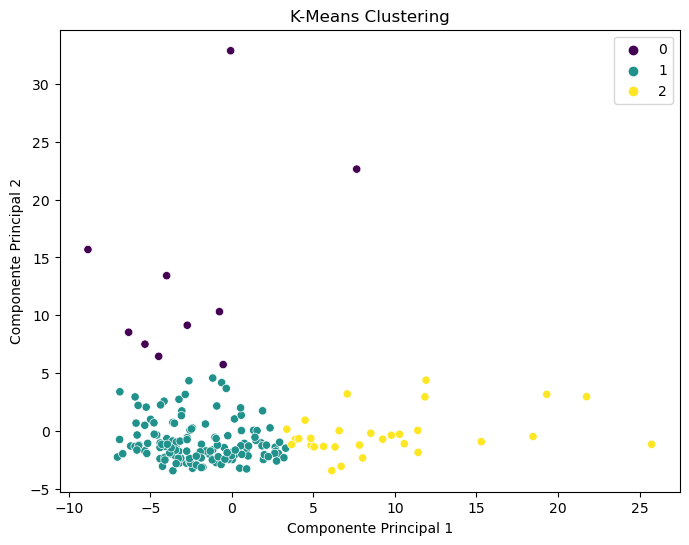

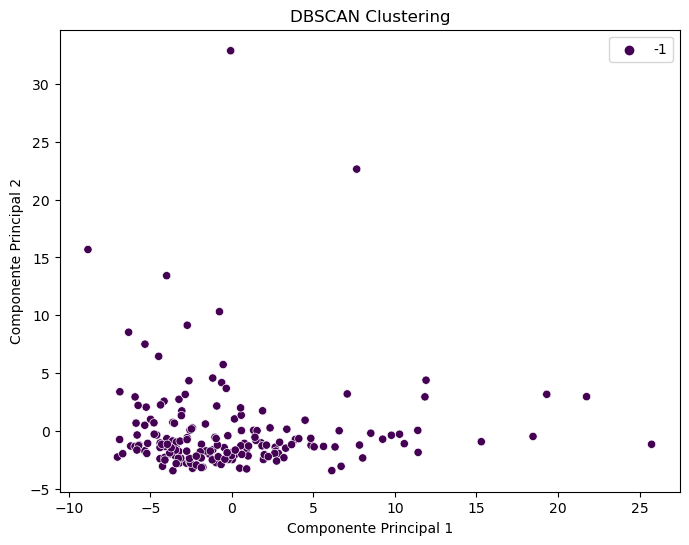

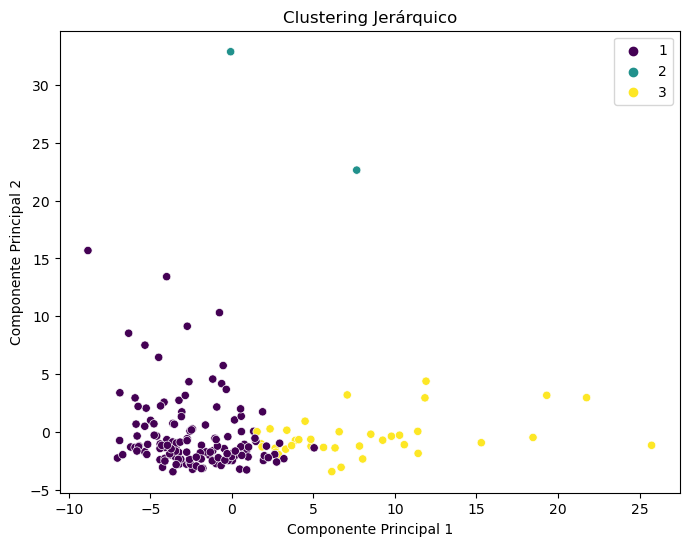

In [3]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Seleccionar columnas numéricas relevantes para el clustering
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
data = df[numerical_columns].dropna()

# Escalar los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Aplicar K-Means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(data_scaled)
kmeans_silhouette = silhouette_score(data_scaled, kmeans_labels)

# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(data_scaled)
dbscan_silhouette = silhouette_score(data_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1

# Aplicar Clustering Jerárquico
linkage_matrix = linkage(data_scaled, method='ward')
hierarchical_labels = fcluster(linkage_matrix, t=3, criterion='maxclust')
hierarchical_silhouette = silhouette_score(data_scaled, hierarchical_labels)

# Elegir el mejor algoritmo
scores = {
    'K-Means': kmeans_silhouette,
    'DBSCAN': dbscan_silhouette,
    'Jerárquico': hierarchical_silhouette
}
best_algorithm = max(scores, key=scores.get)
print(f"Mejor algoritmo según la métrica de silueta: {best_algorithm}")

# Reducir dimensionalidad con PCA para graficar
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Función para graficar resultados
def plot_clusters(labels, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=labels, palette='viridis', legend='full')
    plt.title(title)
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.show()

# Graficar cada resultado
plot_clusters(kmeans_labels, "K-Means Clustering")
plot_clusters(dbscan_labels, "DBSCAN Clustering")
plot_clusters(hierarchical_labels, "Clustering Jerárquico")
